# Week 8 (Revised): Finalizing Outputs for Final Project

### By Mica O'Brien

In this Jupyter notebook, I finalize code and outputs for my final project. I merge the affordable housing, parks, neighborhood boundaries, and racial demographics datasets to determine the racial make-up of neighborhoods of interest (Boyle Heights, Pacific Palisades, San Pedro, and Westlake). I also calculate distances between affordable housing developments and parks by neighborhood. I conduct spatial autocorrelation and statistical tests to determine if the differences we observe across neighborhoods are significant. There is a statistical difference in average distances between East and Westside neighborhoods, but these are largely due to disparities in numbers of affordable housing developments across the city. 

In [246]:
!pip install -U geopandas

I was having issues running one of the join commands below, so start by reinstalling geopandas, which allows the join code to run. 

In [247]:
import pandas as pd

import geopandas as gpd

import contextily as ctx

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

import matplotlib.pyplot as plt
import plotly.express as px

import folium

I import the libraries I will need for this notebook. 

### Affordable Housing Cleaning

Like my Week 7 notebook, I read in the affordable housing and parks data. I do some light cleaning of the affordable housing data. 

In [248]:
AH = gpd.read_file('Affordable_Housing_Development-Copy1.geojson')

I read in the affordable housing data. 

In [249]:
Greenspace = gpd.read_file('ParkBoundaries.geojson')

Then, I read in the parks data. 

In [250]:
columns_revised = ['OBJECTID', 'PROJECT_NA', 'AV_ADD', 'geometry']

As I've done in previous notebooks, I cut unnecessary columns from the affordable housing dataset to make it easier to work with. 

In [251]:
AH = AH[columns_revised]

I resave the affordable housing dataset with the 4 remaining columns. 


In [252]:
AH.columns = ['object_id', 'project_name', 'av_address', 'geometry']

I rename the columns (change them from all caps to lowercase) to make them more consistent and easier to work with. I resave the dataset with the renamed columns. 

### Neighborhood Boundaries

In this section I conduct a spatial join between the neighborhood boundary GeoJSON and the affordable housing dataset to determine number of developments per neighborhood. I've done this in previous notebooks but need to do it again here.

In [253]:
neighborhoods2 = gpd.read_file("LA_Times_Neighborhood_Boundaries (1)-Copy1.geojson")

I start by reading in the neighborhood boundary GeoJSON file. 

In [254]:
AH_by_neighborhood2 = gpd.sjoin(neighborhoods2, AH) 

I conduct a spatial join with the affordable housing data and the neighborhood boundary data. 

In [255]:
projects_per_community_counts2 = AH_by_neighborhood2.value_counts('name').reset_index(name='projects_per_community_counts2')
projects_per_community_counts2

name  projects_per_community_counts2
0           Westlake                             146
1           Downtown                             127
2         Pico-Union                             105
3    North Hollywood                             101
4      Boyle Heights                              98
..               ...                             ...
98          Westwood                               1
99      Porter Ranch                               1
100        Larchmont                               1
101      Playa Vista                               1
102     Shadow Hills                               1

[103 rows x 2 columns]

I want to calculate the number of affordable housing developments by neighborhood, so create a new dataframe called "projects_per_community_counts2".

In [256]:
AH_byneighborhood3 = neighborhoods2.merge(projects_per_community_counts2, how='left', on='name')

I merge the new dataframe with the affordable housing and neighborhood boundary dataframe. 

In [257]:
AH_byneighborhood3 = AH_byneighborhood3.sort_values(by='projects_per_community_counts2', ascending=False)

I order the data by the "projects_per_community_counts2" variable in ascending order (from neighborhoods with the largest number of developments to neighborhoods with the smallest number of developments). 

### Joining Neighborhoods and Census Tracts

Next, I read in racial demographics data from Census Reporter and join it with the neighborhood boundaries GeoJSON. This allows me to pull racial demographics by neighborhood (as opposed to census tracts). I create plotly bar charts of racial demographics by neighborhood for our storymap. The majority of residents in Westlake, San Pedro, and Boyle Heights identify as Hispanic. In Pacific Palisades, most residents identify as white. 

In [258]:
census = gpd.read_file('acs2019_5yr_B03002_14000US06037222001.geojson')

I read in the census file. 

In [259]:
columns_to_keep = ['geoid',
 'name',
 'B03002001',
 'B03002002',
 'B03002003',
 'B03002004',
 'B03002005',
 'B03002006',
 'B03002007',
 'B03002008',
 'B03002009',
 'B03002012',
 'geometry']

I consulted with Estefany about which columns we want to keep. I cut unnecessary columns. 

In [260]:
census = census[columns_to_keep]

I save the dataframe with the revised column list. 

In [261]:
census.columns = ['geoid',
 'name',
 'total',
 'non hispanic',
 'white',
 'black',
 'native',
 'asian',
 'pacific islander',
 'non hispanic some other race',
 'non hispanic two or more races',
 'hispanic',
 'geometry']

I rename the columns to make them easier to work with. As you can see, they include raw numbers of people by racial group. I will need to normalize the data, which I do below. 

In [262]:
census['Percent Non-Hispanic'] = census['non hispanic']/census['total']*100
census['Percent Hispanic'] = census['hispanic']/census['total']*100
census['Percent White'] = census['white']/census['total']*100
census['Percent Black'] = census['black']/census['total']*100
census['Percent Native'] = census['native']/census['total']*100
census['Percent Asian'] = census['asian']/census['total']*100
census['Percent Pacific Islander'] = census['pacific islander']/census['total']*100
census['Percent Non-Hispanic, Some Other Race'] = census['non hispanic some other race']/census['total']*100
census['Percent Non-Hispanic, Two or More Races'] = census['non hispanic two or more races']/census['total']*100

I normalize the data by creating 9 new columns. I create percentages for each racial group from the raw numbers. 

In [263]:
points = census.copy()

In order to join the census data with the neighborhood boundary file, I need to identify the points of each of the census tract polygons. This will allow me to match the neighborhood boundaries with the census tract boundaries. 

In [264]:
points.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

I check the projection for the new points dataframe. The EPSG is 4326.

In [265]:
neighborhoods2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

I do the same for the neighborhood boundary file. The EPSG is also 4326, which means I can continue. 

In [266]:
points['geometry'] = points['geometry'].centroid

/tmp/ipykernel_55/3912728631.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




I identify the centroid of each of the census tract polygons. This will make it easier to conduct the spatial join with the neighborhood GeoJSON. Each neighborhood boundary will match with the centroids of corresponding census tracts. 

In [267]:
neighborhoods_with_tracts = gpd.sjoin(census, neighborhoods2, how="left", op='within')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



I conduct the spatial join between the census tract centroids and the neighborhood boundaries. I indicate "within" so that the neighorhood boundaries include all census tract centroids within its boundaries. 

In [268]:
neighborhoods_with_tracts.head(5)

geoid                              name_left   total  \
0  14000US06037101110  Census Tract 1011.10, Los Angeles, CA  4283.0   
1  14000US06037101122  Census Tract 1011.22, Los Angeles, CA  3405.0   
2  14000US06037101210  Census Tract 1012.10, Los Angeles, CA  6347.0   
3  14000US06037101220  Census Tract 1012.20, Los Angeles, CA  3702.0   
4  14000US06037101300     Census Tract 1013, Los Angeles, CA  3884.0   

   non hispanic   white  black  native  asian  pacific islander  \
0        3095.0  2616.0   19.0     3.0  331.0               3.0   
1        3258.0  2882.0   74.0    15.0  220.0               0.0   
2        3731.0  2986.0  198.0     0.0  486.0               0.0   
3        2338.0  1812.0   87.0     0.0  341.0               0.0   
4        3587.0  3126.0  205.0     0.0  194.0               0.0   

   non hispanic some other race  ...  Percent White  Percent Black  \
0                           8.0  ...      61.078683       0.443614   
1                           0.0  ...      84.640235       2.173275   
2                          47.0  ...      47.045848       3.119584   
3                           0.0  ...      48.946515       2.350081   
4                           0.0  ...      80.484037       5.278064   

  Percent Native  Percent Asian  Percent Pacific Islander  \
0       0.070044       7.728228                  0.070044   
1       0.440529       6.461087                  0.000000   
2       0.000000       7.657161                  0.000000   
3       0.000000       9.211237                  0.000000   
4       0.000000       4.994851                  0.000000   

   Percent Non-Hispanic, Some Other Race  \
0                               0.186785   
1                               0.000000   
2                               0.740507   
3                               0.000000   
4                               0.000000   

   Percent Non-Hispanic, Two or More Races  index_right  OBJECTID  name_right  
0                                 2.685034         92.0      93.0     Tujunga  
1                                 1.967695          NaN       NaN         NaN  
2                                 0.220577         92.0      93.0     Tujunga  
3                                 2.647218         92.0      93.0     Tujunga  
4                                 1.596292          NaN       NaN         NaN  

[5 rows x 25 columns]

I use the .head() command to make sure the join worked. It looks like it did!

In [269]:
race_add = neighborhoods_with_tracts.dissolve(by='name_right', aggfunc='mean')

In [270]:
race_add.reset_index(inplace=True)
race_add= race_add.rename(columns = {'name_right':'name_right'})

In the two lines of code above, I create a new dataframe, "race_add", which summarizes all of the census tract data for each neighborhood into one row. This makes the data easier to work with. I reset the index so that the name of the neighborhood is the first column. 

In [271]:
race_add.head()

name_right                                           geometry  \
0         Adams-Normandie  POLYGON ((-118.29915 34.03273, -118.29807 34.0...   
1       Arlington Heights  POLYGON ((-118.32366 34.04585, -118.32334 34.0...   
2  Baldwin Hills/Crenshaw  POLYGON ((-118.34724 34.01313, -118.34740 34.0...   
3           Boyle Heights  POLYGON ((-118.21885 34.02907, -118.21877 34.0...   
4     Broadway-Manchester  POLYGON ((-118.28000 33.93113, -118.27992 33.9...   

    total  non hispanic       white        black     native       asian  \
0  3945.5        1128.5  142.000000   804.000000   0.000000  134.500000   
1  4638.0        1312.0  102.000000   514.000000   0.000000  587.000000   
2  3997.0        2355.0  184.000000  1880.000000  14.666667  147.333333   
3  4027.0         260.8   90.466667    49.933333   5.600000  103.866667   
4  5146.0        1518.0   38.000000  1350.000000   0.000000   85.000000   

   pacific islander  non hispanic some other race  ...  Percent Hispanic  \
0         29.000000                           8.0  ...         71.352644   
1         11.000000                           0.0  ...         71.711945   
2          3.666667                          11.0  ...         39.284929   
3          0.000000                           2.6  ...         94.001005   
4          0.000000                          18.0  ...         70.501360   

   Percent White  Percent Black  Percent Native  Percent Asian  \
0       3.592032      20.439876        0.000000       3.393953   
1       2.199224      11.082363        0.000000      12.656317   
2       4.467720      48.746914        0.470696       3.764044   
3       2.189728       1.248016        0.111741       2.180741   
4       0.738438      26.233968        0.000000       1.651768   

   Percent Pacific Islander  Percent Non-Hispanic, Some Other Race  \
0                  0.748387                               0.199203   
1                  0.237171                               0.000000   
2                  0.117937                               0.353193   
3                  0.000000                               0.080803   
4                  0.000000                               0.349786   

   Percent Non-Hispanic, Two or More Races  index_right  OBJECTID  
0                                 0.273904          0.0       1.0  
1                                 2.112980          2.0       3.0  
2                                 2.794567          4.0       5.0  
3                                 0.187964          9.0      10.0  
4                                 0.524679         11.0      12.0  

[5 rows x 23 columns]

I check to make sure the data is looking the way I want it to. It is!

## Working with Individual Neighborhoods

Now that I have successfully joined my neighborhood boundary and census data, I can hone in on our 4 neighborhoods of interest: Boyle Heights, Pacific Palisades, San Pedro, and Westlake. I pull out the racial demographic data for each of the neighborhoods and create new dataframes. Then I create additional dataframes for my plolty bar charts, which show percentages of racial groups by neighborhood. 

In [272]:
boyleHeights = race_add[race_add['name_right'] == 'Boyle Heights']
boyleHeights

name_right                                           geometry   total  \
3  Boyle Heights  POLYGON ((-118.21885 34.02907, -118.21877 34.0...  4027.0   

   non hispanic      white      black  native       asian  pacific islander  \
3         260.8  90.466667  49.933333     5.6  103.866667               0.0   

   non hispanic some other race  ...  Percent Hispanic  Percent White  \
3                           2.6  ...         94.001005       2.189728   

   Percent Black  Percent Native  Percent Asian  Percent Pacific Islander  \
3       1.248016        0.111741       2.180741                       0.0   

   Percent Non-Hispanic, Some Other Race  \
3                               0.080803   

   Percent Non-Hispanic, Two or More Races  index_right  OBJECTID  
3                                 0.187964          9.0      10.0  

[1 rows x 23 columns]

I create a new dataframe for Boyle Heights. The dataframe pulls from the "race_add" dataframe but only includes racial demographic information for Boyle Heights. I check to make sure it worked. 

In [273]:
pacificPalisades = race_add[race_add['name_right'] == 'Pacific Palisades']
pacificPalisades

name_right                                           geometry  \
38  Pacific Palisades  MULTIPOLYGON (((-118.52900 34.05014, -118.5289...   

     total  non hispanic   white  black  native  asian  pacific islander  \
38  3662.0        3478.0  2902.5   23.0     4.5  244.0               0.0   

    non hispanic some other race  ...  Percent Hispanic  Percent White  \
38                          10.0  ...          5.044944      79.000094   

    Percent Black  Percent Native  Percent Asian  Percent Pacific Islander  \
38       0.649901         0.11889       6.740338                       0.0   

    Percent Non-Hispanic, Some Other Race  \
38                               0.282566   

    Percent Non-Hispanic, Two or More Races  index_right  OBJECTID  
38                                 8.163267         68.0      69.0  

[1 rows x 23 columns]

I do the same for Palisades. 

In [274]:
sanPedro = race_add[race_add['name_right'] == 'San Pedro']
sanPedro

name_right                                           geometry     total  \
45  San Pedro  POLYGON ((-118.29282 33.72136, -118.29279 33.7...  4243.875   

    non hispanic    white  black  native    asian  pacific islander  \
45        1622.0  950.125  313.5     5.5  236.375             7.375   

    non hispanic some other race  ...  Percent Hispanic  Percent White  \
45                          7.25  ...         60.886375      23.355649   

    Percent Black  Percent Native  Percent Asian  Percent Pacific Islander  \
45       7.150131        0.125612       5.813287                  0.175232   

    Percent Non-Hispanic, Some Other Race  \
45                               0.146932   

    Percent Non-Hispanic, Two or More Races  index_right  OBJECTID  
45                                 2.346783         79.0      80.0  

[1 rows x 23 columns]

I do the same for San Pedro.

In [275]:
Westlake = race_add[race_add['name_right'] == 'Westlake']
Westlake

name_right                                           geometry        total  \
65   Westlake  POLYGON ((-118.27140 34.05350, -118.27166 34.0...  3863.210526   

    non hispanic       white       black    native       asian  \
65   1146.947368  244.631579  180.684211  8.526316  659.210526   

    pacific islander  non hispanic some other race  ...  Percent Hispanic  \
65          8.157895                      4.947368  ...          70.90758   

    Percent White  Percent Black  Percent Native  Percent Asian  \
65       6.328757       4.506369        0.208969      16.655917   

    Percent Pacific Islander  Percent Non-Hispanic, Some Other Race  \
65                  0.194469                               0.132018   

    Percent Non-Hispanic, Two or More Races  index_right  OBJECTID  
65                                  1.06592        106.0     107.0  

[1 rows x 23 columns]

I do the same for Westlake. 

In [276]:
boyleHeights1 = pd.DataFrame({'race':['Hispanic', 'White', 'Asian', 'Black'], 'percent':[94,2.19,2.18,1.25]})

Next, I go back to Boyle Heights. I create a new 2-column dataframe of the top 4 racial groups in the neighborhood. This will allow me to more easily create a bar chart. I include racial groups with 1% or greater of the population. 

In [277]:
boyleHeights1.head(10)

race  percent
0  Hispanic    94.00
1     White     2.19
2     Asian     2.18
3     Black     1.25

I take a look at the new dataframe. It's looking good!

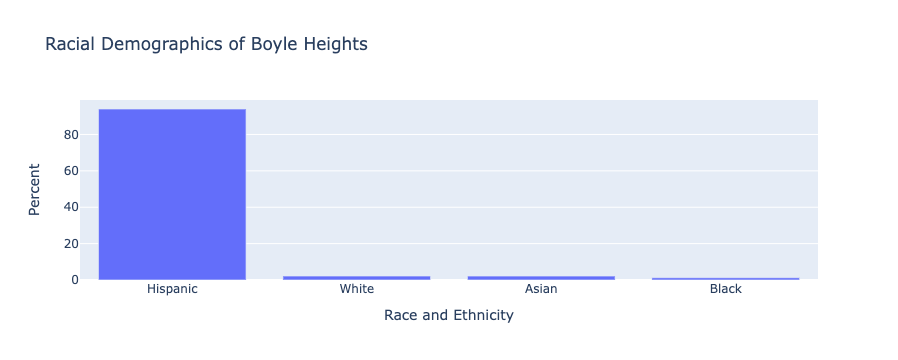

In [278]:
fig1 = px.bar(boyleHeights1, x='race', 
             y='percent', 
            title='Racial Demographics of Boyle Heights',
            hover_data=['race', 'percent'], 
             labels={
                 'race':'Race and Ethnicity', 'percent':'Percent'}
             )
fig1.show()

I produce a bar chart. Now we can clearly see that Boyle Heights is predominantly Hispanic. 

In [279]:
pacificPalisades1 = pd.DataFrame({'race':['White', 'Non-Hispanic, Two or More Races','Asian', 'Hispanic'], 'percent':[79,8.16,6.74,5.04]})

I create a new 2-column dataframe of the top 4 racial groups in Pacific Palisades.

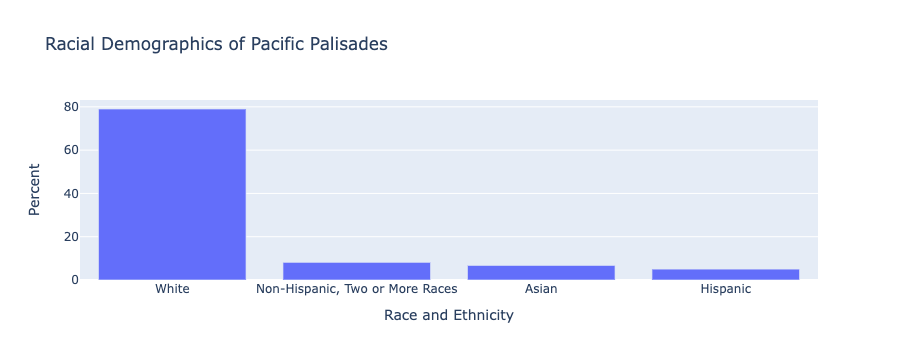

In [280]:
fig2 = px.bar(pacificPalisades1, x='race', 
             y='percent', 
            title='Racial Demographics of Pacific Palisades',
            hover_data=['race', 'percent'], 
             labels={
                 'race':'Race and Ethnicity', 'percent':'Percent'}
             )
fig2.show()

I produce a bar chart. The majority of Pacific Palisades residents identify as white. 

In [281]:
sanPedro1 = pd.DataFrame({'race':['Hispanic','White','Black','Asian', 'Non-Hispanic, Two or More Races'], 'percent':[60.89,23.36,7.15,5.81,2.35]})

I create a new 2-column dataframe of the top 4 racial groups in San Pedro. 

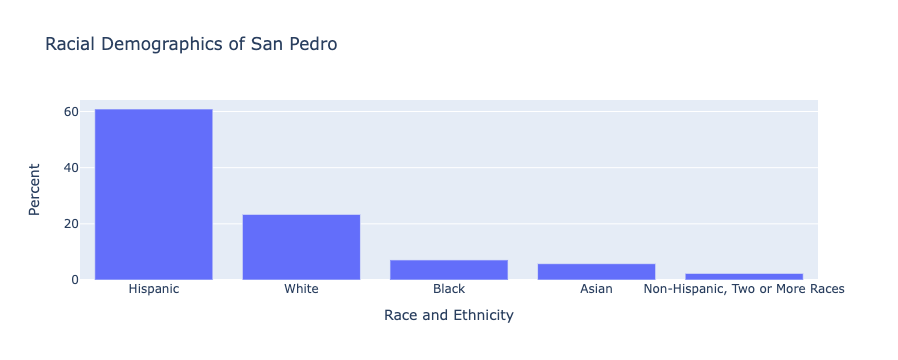

In [282]:
fig3 = px.bar(sanPedro1, x='race', 
             y='percent', 
            title='Racial Demographics of San Pedro',
            hover_data=['race', 'percent'], 
             labels={
                 'race':'Race and Ethnicity', 'percent':'Percent'}
             )
fig3.show()

I produce a bar chart. The (slight) majority of San Pedro residents identify as Hispanic. 

In [283]:
Westlake1 = pd.DataFrame({'race':['Hispanic','Asian','White','Black','Non-Hispanic, Two or More Races'], 'percent':[70.91,16.66,6.33,4.51,1.1]})

I create a new 2-column dataframe of the top 4 racial groups in Westlake. 

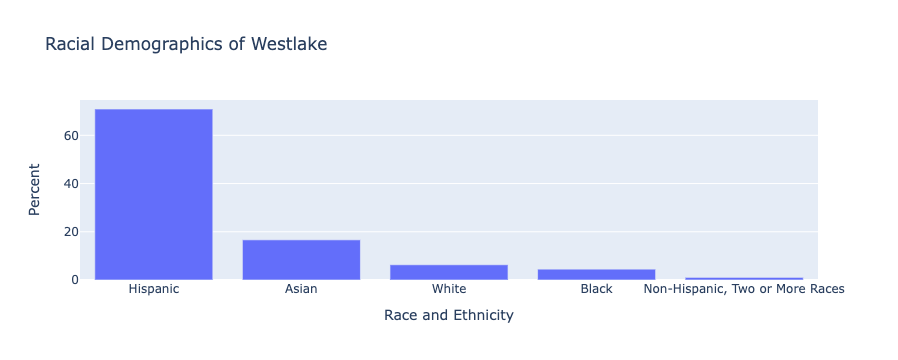

In [284]:
fig4 = px.bar(Westlake1, x='race', 
             y='percent', 
            title='Racial Demographics of Westlake',
            hover_data=['race', 'percent'], 
             labels={
                 'race':'Race and Ethnicity', 'percent':'Percent'}
             )
fig4.show()

I produce a bar chart. The majority of Westlake residents identify as Hispanic.

## Merging Census, Neighborhood Boundary, Affordable Housing, and Parks Data

Now that I've successfully merged the census and neighborhood boundary data, I can turn back to the affordable housing and parks data. In this section, I remerge the affordable housing and parks datasets and calculate average distances between them. I bring in the neighborhood boundary GeoJSON to determine average distances between affordable housing and parks across neighborhoods. 

In [285]:
AH = AH.to_crs(epsg=6424)

In [286]:
Greenspace = Greenspace.to_crs(epsg=6424)

I change the projection of my affordable housing and parks datasets to 6424 so that I calculate distances between affordable housing and parks in feet. This will make more sense in a bit! 

In [287]:
AH_Parks = gpd.sjoin_nearest(AH, Greenspace, distance_col="distances", how="inner")

I conduct a spatial join between the affordable housing and parks data, creating a new column called "distances" which indicates distances between each affordable housing development and its nearest park in feet. 

In [288]:
AH_Parks.head()

object_id                   project_name               av_address  \
0             1  1747 Normandie (Casa Dinivid)   1747 N. NORMANDIE AVE.   
31           32              LA Pro XXXII Apts  1801 N. ALEXANDRIA AVE.   
449         450                Princess Apts/2     1648 N. KINGSLEY DR.   
832         833                 Kingswood APTS  5169 W. HOLLYWOOD BLVD.   
1023       1024          1340 N. MARIPOSA APTS    1340 N. MARIPOSA AVE.   

                             geometry  index_right              address  \
0     POINT (6470680.422 1859866.978)           40  4800 Hollywood Blvd   
31    POINT (6471342.892 1860209.821)           40  4800 Hollywood Blvd   
449   POINT (6469858.918 1859243.538)           40  4800 Hollywood Blvd   
832   POINT (6470030.003 1859555.371)           40  4800 Hollywood Blvd   
1023  POINT (6471011.075 1857412.136)           40  4800 Hollywood Blvd   

                name objectid    distances  
0     Barnsdall Park       37  1628.031341  
31    Barnsdall Park       37  1160.703338  
449   Barnsdall Park       37  2350.389254  
832   Barnsdall Park       37  2209.840413  
1023  Barnsdall Park       37  1848.191501

I use the .head() command to make sure that the join worked. It looks like it did! The distances appear to make sense as well.

In [289]:
AH_Parks['distances'].mean()

1657.3199433437205

In [290]:
AH_Parks['distances'].median()

1417.0340735034467

Next, I calculate the mean and median distance (ft) between affordable housing developments and parks. The mean distance is .31 miles and the median distance is .27 miles.

In [291]:
AH_Parks.drop('index_right', axis=1, inplace=True)

I want to join the neighborhood boundary data to my AH_Parks dataframe to calculate average distance between affordable housing developments and parks by neighborhood. Before I can do that, I need to drop the added "index_right" column, which was creating issues. The neighborhoods dataframe also has an "index_right" column. I have to delete the "index_right" column in the affordable housing and parks dataframe so that it can successfully join with the neighborhood boundary dataframe.

In [292]:
neighborhoods2 = neighborhoods2.to_crs(epsg=6424)

I also need to make sure that the the neighborhoods dataframe has the same projection (6424) as the affordable housing dataframe, which I do above. 

In [293]:
neighborhoods_AH_Parks = gpd.sjoin(AH_Parks, neighborhoods2, how="left", op='within')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



Now I can conduct the spatial join between the affordable housing and parks dataframe and the neighborhood boundary dataframe.

In [294]:
neighborhoods_AH_Parks.head()

object_id                   project_name               av_address  \
0             1  1747 Normandie (Casa Dinivid)   1747 N. NORMANDIE AVE.   
31           32              LA Pro XXXII Apts  1801 N. ALEXANDRIA AVE.   
449         450                Princess Apts/2     1648 N. KINGSLEY DR.   
832         833                 Kingswood APTS  5169 W. HOLLYWOOD BLVD.   
1023       1024          1340 N. MARIPOSA APTS    1340 N. MARIPOSA AVE.   

                             geometry              address       name_left  \
0     POINT (6470680.422 1859866.978)  4800 Hollywood Blvd  Barnsdall Park   
31    POINT (6471342.892 1860209.821)  4800 Hollywood Blvd  Barnsdall Park   
449   POINT (6469858.918 1859243.538)  4800 Hollywood Blvd  Barnsdall Park   
832   POINT (6470030.003 1859555.371)  4800 Hollywood Blvd  Barnsdall Park   
1023  POINT (6471011.075 1857412.136)  4800 Hollywood Blvd  Barnsdall Park   

     objectid    distances  index_right  OBJECTID      name_right  
0          37  1628.031341         57.0      58.0       Los Feliz  
31         37  1160.703338         57.0      58.0       Los Feliz  
449        37  2350.389254         25.0      26.0  East Hollywood  
832        37  2209.840413         57.0      58.0       Los Feliz  
1023       37  1848.191501         25.0      26.0  East Hollywood

I check to make sure it worked. Looks like it did!

In [295]:
avg_dist = neighborhoods_AH_Parks.groupby('name_right').agg({'distances':'mean'})

I create a new dataframe of average distances between affordable housing and parks by neighborhood. 

In [296]:
avg_dist1 = neighborhoods2.merge(avg_dist, right_on="name_right", left_on="name")

I create another new dataframe where I merge average distances by neighborhood to the original neighborhood boundary GeoJSON. It will be easier to work with this dataframe to pull out distances by neighborhood. 

In [297]:
avg_dist1.head()

OBJECTID                    name  \
0         1         Adams-Normandie   
1         2                  Arleta   
2         3       Arlington Heights   
3         5  Baldwin Hills/Crenshaw   
4         8           Beverly Grove   

                                            geometry    distances  
0  POLYGON ((6470569.039 1836097.658, 6469600.038...  1168.048336  
1  POLYGON ((6427954.037 1918795.544, 6427997.447...  1707.109197  
2  POLYGON ((6465152.923 1841844.649, 6465726.604...  2057.356317  
3  POLYGON ((6452273.683 1831791.542, 6452503.870...  1471.942733  
4  POLYGON ((6448880.318 1855438.830, 6448877.881...  2932.233778

I take a look at the data. I'm now ready to pull out distances for my 4 neighborhoods of interest: Boyle Heights, Pacific Palisades, San Pedro, and Westlake. 

In [298]:
boyleHeights1 = avg_dist1[avg_dist1['name'] == 'Boyle Heights']
boyleHeights1

OBJECTID           name                                           geometry  \
5        10  Boyle Heights  POLYGON ((6503322.925 1844553.408, 6503329.176...   

     distances  
5  1102.729598

I create a new dataframe for average distance in Boyle Heights. The average distance between affordable housing and parks is 1,102 ft or .21 miles. 

In [299]:
boyleHeights2 = neighborhoods_AH_Parks[neighborhoods_AH_Parks['name_right'] == 'Boyle Heights']
boyleHeights2['distances'].median()

840.1135889782644

The median distance between affordable housing and parks in Boyle Heights is 840 ft or .16 miles

In [300]:
pacificPalisades1 = avg_dist1[avg_dist1['name'] == 'Pacific Palisades']
pacificPalisades1

OBJECTID               name  \
59        69  Pacific Palisades   

                                             geometry   distances  
59  POLYGON ((6393085.193 1868896.282, 6393188.675...  743.912576

I create a new dataframe for average distance in Pacific Palisades. The average distance betweeen affordable housing and parks is 744 ft or .14 miles. 

In [301]:
pacificPalisades2 = neighborhoods_AH_Parks[neighborhoods_AH_Parks['name_right'] == 'Pacific Palisades']
pacificPalisades2['distances'].mean()

743.9125758931192

The median distance between affordable housing and parks in Pacific Palisades is 744 ft or .14 miles.

In [302]:
sanPedro1 = avg_dist1[avg_dist1['name'] == 'San Pedro']
sanPedro1

OBJECTID       name                                           geometry  \
69        80  San Pedro  MULTIPOLYGON (((6473981.360 1733120.867, 64739...   

      distances  
69  1143.026651

I create a new dataframe for average distance in San Pedro. The average distance between affordable housing and parks is 1,143 ft or .22 miles. 

In [303]:
sanPedro2 = neighborhoods_AH_Parks[neighborhoods_AH_Parks['name_right'] == 'San Pedro']
sanPedro2['distances'].median()

1113.9253936265854

The median distance between affordable housing and parks in San Pedro is 1,113 ft or .21 miles.

In [304]:
Westlake1 = avg_dist1[avg_dist1['name'] == 'Westlake']
Westlake1

OBJECTID      name                                           geometry  \
95       107  Westlake  POLYGON ((6483189.757 1842096.328, 6482960.309...   

     distances  
95  983.148137

I create a new dataframe for average distance in Westlake. The average distance between affordable housing and parks is 974 ft or .19 miles.

In [305]:
Westlake2 = neighborhoods_AH_Parks[neighborhoods_AH_Parks['name_right'] == 'Westlake']
Westlake2['distances'].median()

974.1495621922036

The median distance between affordable housing and parks in Westlake is 974 ft or .18 miles.

In [306]:
bh1_pp1 = boyleHeights1.append(pacificPalisades1)

To create a bar chart of average distances across the 4 neighborhoods, I need to append the dataframes. I start by appending the Pacific Palisades dataframe to the Boyle Heights dataframe.

In [307]:
bh1_pp1_sp1 = bh1_pp1.append(sanPedro1)

I then append the San Pedro dataframe to the Boyle Heights and Pacific Palisades dataframe.

In [308]:
bh1_pp1_sp1_w1 = bh1_pp1_sp1.append(Westlake1)

I append the Westlake dataframe to the Boyle Heights, Pacific Palisades, and San Pedro dataframe. 

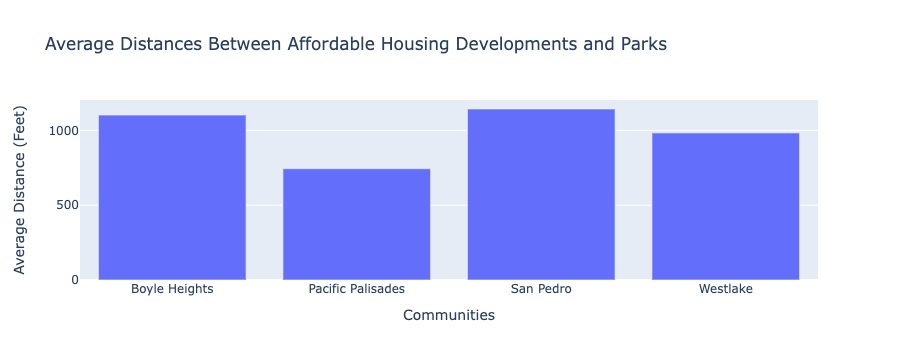

In [309]:
fig6 = px.bar(bh1_pp1_sp1_w1, x="name", 
             y="distances", 
            title='Average Distances Between Affordable Housing Developments and Parks',
            labels={
                 'name':'Communities', 'distances':'Average Distance (Feet)'}
             )
fig6.show()

I create a bar chart of the average distances between affordable housing and parks by neighborhood. As you can see, Pacifc Palisades has the shortest distance between affordable housing and parks; however, this data is likely skewed given that there is only 1 affordable housing development in Pacific Palisades. San Pedro has the largest distance, but it is also the largest neighborhood of the 4. This will need to be taken into account in our analysis. 

Text(0.5, 1.0, 'Average Distances (Ft) Between Affordable Housing and Parks')

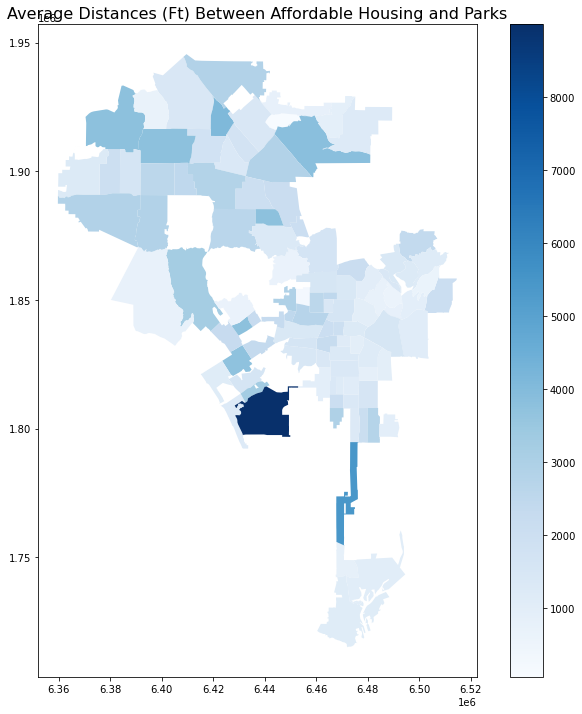

In [310]:
fig,ax = plt.subplots(figsize=(12,12))

avg_dist1.plot(ax=ax,column='distances',legend=True,cmap='Blues')

ax.set_title('Average Distances (Ft) Between Affordable Housing and Parks',fontsize=16)

Lastly, I create a chloropleth map of average distances across all neighborhoods in Los Angeles. It appears that there is a greater distance between affordable housing and parks in neighborhoods on the Westside; however, this is likely due to the size of the neighborhoods and the small number of affordable housing developments. Neighborhoods in South/Central LA are smaller with more affordable housing developments. I dig into this a little more in the spatial autocorrelation section below.

## Spatial Autocorrelation

I want to dig a bit deeper into my findings on distances between affordable housing and parks. I perform a spatial autocorrelation to determine whether the differences in distances are statistically significant. I ultimately determine that differences are statsitically significant between the East and Westside. However, I believe these differences are largely due to differences in numbers of developments across neighborhoods and not due to actual differences in distances. 

In [311]:
wq =  lps.weights.KNN.from_dataframe(avg_dist1,k=8)

wq.transform = 'r'

I start by calculating the spatial weight for my avg_dist1 dataframe and standardizing the rows. 

In [312]:
avg_dist1['distances_lag'] = lps.weights.lag_spatial(wq, avg_dist1['distances'])

I create a new column called "distances_lag" which calculates the spatial lag values for all distances by neighborhood. 

In [313]:
avg_dist1['distances_diff'] = avg_dist1['distances'] - avg_dist1['distances_lag']

I create another new column that calculates the difference between the original distance value and the spatial lag value. 

In [314]:
avg_dist1.sort_values(by='distances_diff')

OBJECTID            name  \
86        98          Venice   
97       109        Westwood   
31        41      Hansen Dam   
67        77    Porter Ranch   
65        75   Playa del Rey   
..       ...             ...   
12        17      Chatsworth   
53        63   Mission Hills   
71        83    Shadow Hills   
33        43  Harbor Gateway   
93       105     Westchester   

                                             geometry    distances  \
86  MULTIPOLYGON (((6423334.794 1809038.962, 64229...  1117.965610   
97  POLYGON ((6431620.332 1851499.658, 6431645.992...   683.917400   
31  POLYGON ((6452292.585 1922012.218, 6452585.823...    64.297655   
67  POLYGON ((6401665.960 1916429.270, 6392834.861...   700.891570   
65  POLYGON ((6432086.344 1810852.497, 6432321.280...  1225.880793   
..                                                ...          ...   
12  MULTIPOLYGON (((6361297.583 1900522.443, 63612...  3786.300434   
53  POLYGON ((6420344.580 1928197.938, 6420383.984...  4107.927753   
71  MULTIPOLYGON (((6479877.920 1907191.382, 64801...  3847.298676   
33  POLYGON ((6470987.236 1754515.455, 6467863.251...  5444.617914   
93  POLYGON ((6452945.177 1816169.934, 6452964.086...  8991.755560   

    distances_lag  distances_diff  
86    3409.062672    -2291.097063  
97    2858.000735    -2174.083335  
31    2136.371406    -2072.073750  
67    2644.711854    -1943.820283  
65    3106.855982    -1880.975189  
..            ...             ...  
12    1989.044446     1797.255989  
53    1804.320809     2303.606945  
71    1398.675782     2448.622893  
33    1671.344223     3773.273692  
93    1972.489411     7019.266150  

[103 rows x 6 columns]

I sort the data by the "distances_diff" variable ranging from the lowest values to the highest values. 

In [315]:
avgdist_donut = avg_dist1.sort_values(by='distances_diff').head(1)
avgdist_donut

OBJECTID    name                                           geometry  \
86        98  Venice  MULTIPOLYGON (((6423334.794 1809038.962, 64229...   

     distances  distances_lag  distances_diff  
86  1117.96561    3409.062672    -2291.097063

I create a new dataframe for the neighborhood with the smallest distances_diff value. This will allow me to map the "donut" neighborhood below. 

In [316]:
avgdist_diamond = avg_dist1.sort_values(by='distances_diff').tail(1)
avgdist_diamond

OBJECTID         name                                           geometry  \
93       105  Westchester  POLYGON ((6452945.177 1816169.934, 6452964.086...   

     distances  distances_lag  distances_diff  
93  8991.75556    1972.489411      7019.26615

I create a new dataframe for the neighborhood with the largest distances_diff value. This will allow me to map the "diamond" neighborhood below. 

In [317]:
token = 'pk.eyJ1IjoieW9obWFuIiwiYSI6IkxuRThfNFkifQ.u2xRJMiChx914U7mOZMiZw'
px.set_mapbox_access_token(token)

I bring in Mapbox satellite imagery to better contextualize the donut and diamond neighborhoods. Thanks for letting me use your token, Yoh!

In [318]:
minx, miny, maxx, maxy = avg_dist1.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

6359588.34659966
6514629.231653166
1715036.3727307648
1945517.0534656248


I identify the bounds of the map using minx, miny, maxx, and maxy. 

In [319]:
avgdist_donut = avgdist_donut.to_crs('epsg:4326')

minx, miny, maxx, maxy = avgdist_donut.geometry.total_bounds
center_lat_donut = (maxy-miny)/2+miny
center_lon_donut = (maxx-minx)/2+minx

I project the donut dataframe to 4326 and identify the centroid. 

In [320]:
avgdist_diamond = avgdist_diamond.to_crs('epsg:4326')

minx, miny, maxx, maxy = avgdist_diamond.geometry.total_bounds
center_lat_diamond = (maxy-miny)/2+miny
center_lon_diamond = (maxx-minx)/2+minx

I project the diamond dataframe to 4326 and identify the centroid. 

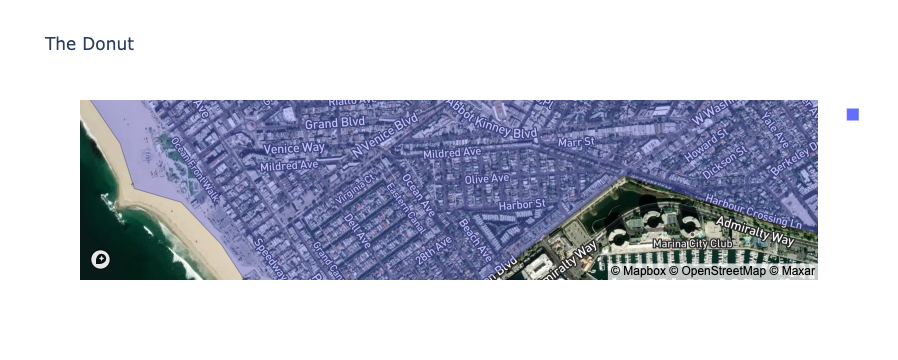

In [321]:
px.choropleth_mapbox(avgdist_donut, 
                     geojson=avgdist_donut.geometry, 
                     locations=avgdist_donut.index, 
                     mapbox_style="satellite-streets",
                     zoom=14, 
                     center = {"lat": center_lat_donut, "lon": center_lon_donut},
                     hover_data=['name','distances'],
                     opacity=0.4,
                     title='The Donut')

Venice is the donut neighborhood. I create a map of the donut neighborhood layered on Mapbox satellite. 

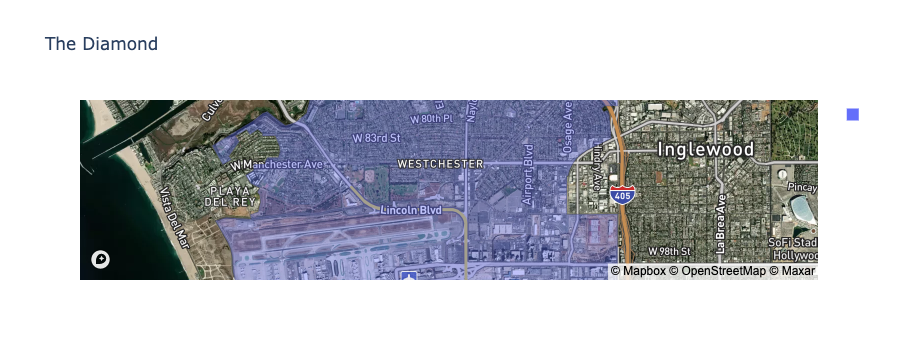

In [322]:
px.choropleth_mapbox(avgdist_diamond, 
                     geojson=avgdist_diamond.geometry, 
                     locations=avgdist_diamond.index, 
                     mapbox_style="satellite-streets",
                     zoom=12, 
                     center = {"lat": center_lat_diamond, "lon": center_lon_diamond},
                     hover_data=['name','distances'],
                     opacity=0.4,
                     title='The Diamond')

Westchester is the diamond neighborhood. I create a map of the diamond neighborhood layered on Mapbox satellite. 

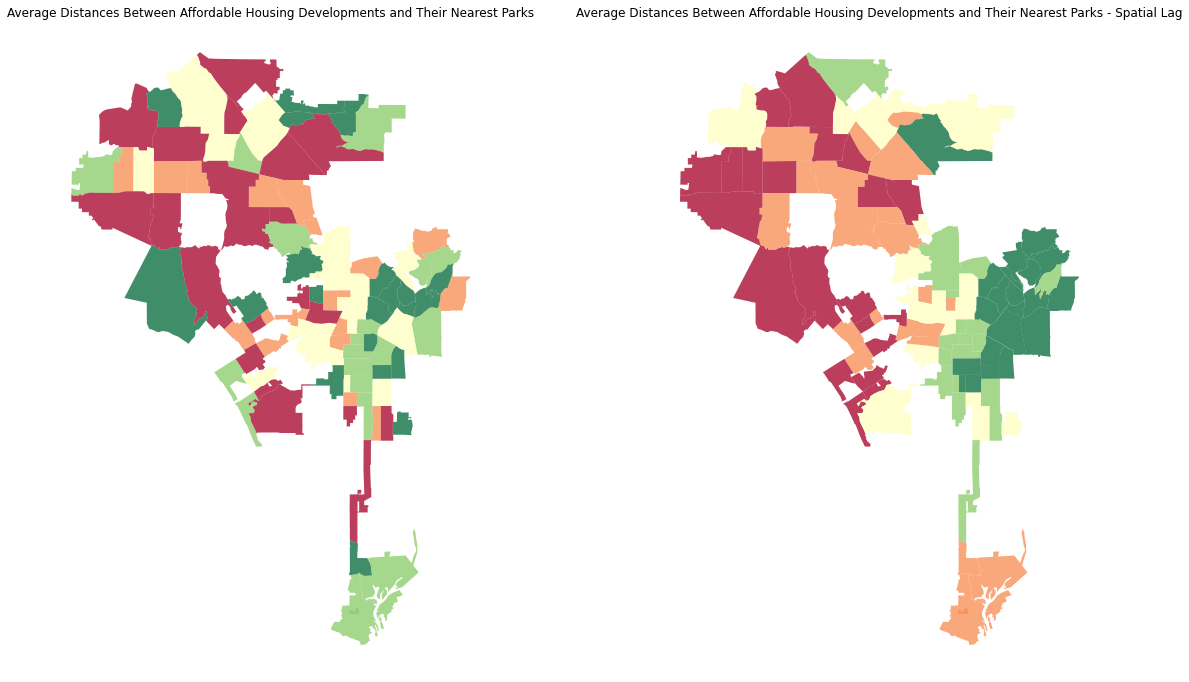

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

avg_dist1.plot(ax=ax[0], # this assigns the map to the left subplot
         column='distances', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Average Distances Between Affordable Housing Developments and Their Nearest Parks")

avg_dist1.plot(ax=ax[1], # this assigns the map to the right subplot
         column='distances_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Average Distances Between Affordable Housing Developments and Their Nearest Parks - Spatial Lag")

plt.show()

I create two maps - the one on the left shows average distances between affordable housing and parks and the one on the right shows spatial lag distances between affordable housing and parks. The map on the right is easier to draw conclusions about. As we can see, distances betwee affordable housing and parks increase from the East to Westside. This is likely due to differences in neighborhood sizes and numbers of affordable housing developments. Because the Westside has fewer developments in general, the average distances are larger. 

In [324]:
gdf_web = avg_dist1.to_crs('EPSG:4326')

Next, I project the avg_dist1 dataframe to 4326. 

In [325]:
minx, miny, maxx, maxy = gdf_web.geometry.total_bounds
center_lat_gdf_web = (maxy-miny)/2+miny
center_lon_gdf_web = (maxx-minx)/2+minx

I calculate the latitude and longitude for each of the neighborhood boundaries.

In [326]:
median = gdf_web.distances_lag.median()

I calculate the median of the avg_dist1 dataframe. 

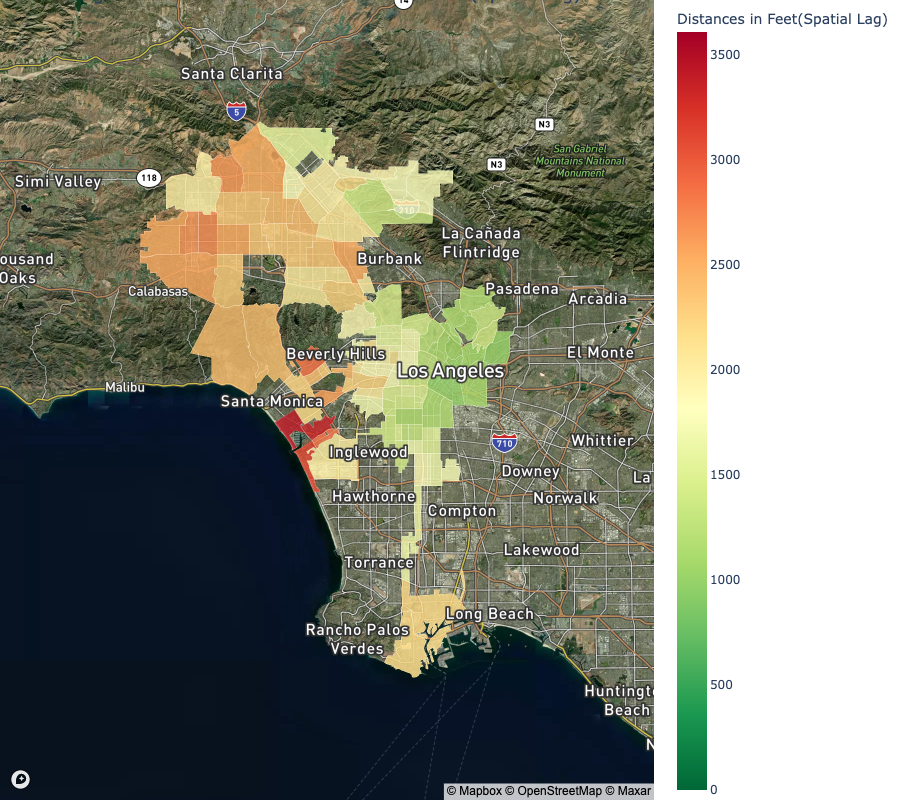

In [327]:
fig = px.choropleth_mapbox(gdf_web, 
                     geojson=gdf_web.geometry, # the geometry column
                     locations=gdf_web.index, # the index
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='distances_lag',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median, # put the median as the midpoint
                     range_color =(0,median*2),
                     hover_data=['name','distances'],
                     center = {"lat": center_lat_gdf_web, "lon": center_lon_gdf_web},
                     opacity=0.8,
                     width=1000,
                     height=800,
                     title='Average Distances Between Affordable and Parks (Spatial Lag)',
                     labels={
                             'distances_lag':'Distances in Feet(Spatial Lag)',
                             'Distances':'Distances Between AH and Parks',
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

I create a chloropleth map of autocorrelated neighborhoods by average distance layered on a satellite map. 

## Moran's Plot

In this last section, I identify neighborhoods with statistically significant differences in distances. A we'll see at the very end, these neighborhoods are clustered on the Westside and Eastside. 

In [328]:
y = avg_dist1.distances
moran = Moran(y, wq)
moran.I

0.06853150330660947

I start by calculating Moran's I value, which is positive.

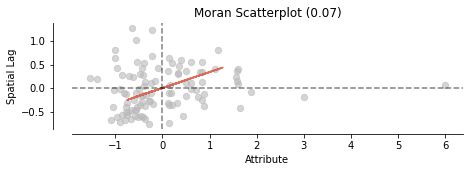

In [329]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

I create a scatter plot of the Moran's I value, which has a positive slope. 

In [330]:
moran.p_sim

0.043

I calculate the p-value to determine the statistical significance of differences in distance. Because the p-value is less than .05 (which is the assumed alpha level), we can reject the null hypothesis. There is a statistically significant difference in distances across neighborhoods.  

In [331]:
lisa = esda.moran.Moran_Local(y, wq)

I calculate the local moran values, which will allow me to classify neighborhoods into 4 groups: neighborhoods with large distances next to other neighborhoods with large distances (HH), neighborhoods with large distances surrounded by neighborhoods with small distances (HL), neighborhoods with small distances next to other neighborhoods with small distances (LL), and neighborhoods with small distances surrounded by neighborhoods with large distances (LH).

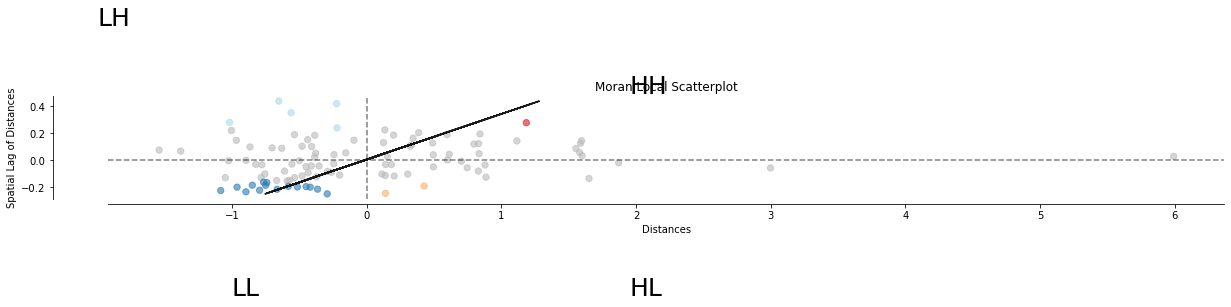

In [332]:
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Distances")
ax.set_ylabel('Spatial Lag of Distances')

plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

I plot the local Moran values. I can see that there are several HH, LL, HL, and LH dots that have p-values of less than .05, which means that they are statistically significant. 

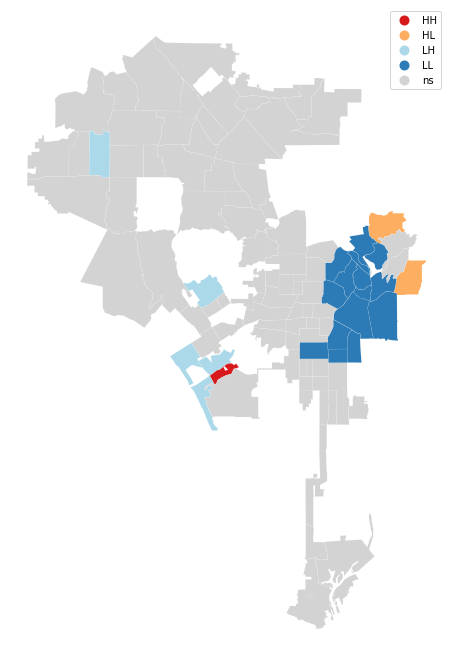

In [335]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, avg_dist1, p=0.05, ax=ax)
plt.show()

I create a chloropleth map of the local Moran values. Several neighborhoods on the Westside have statistically significant distances as do neighborhoods on the Eastside. 

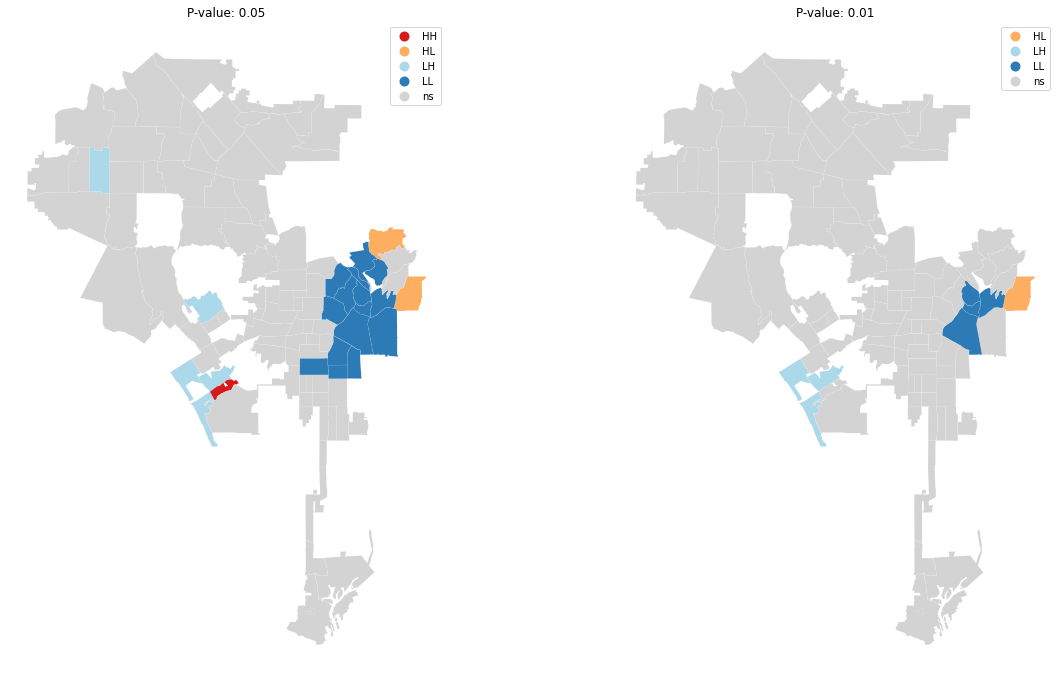

In [334]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

lisa_cluster(lisa, avg_dist1, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, avg_dist1, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

I finish by creating side-by-side maps using different p-values. As noted above, neighborhoods with stastically significant differences in distances are grouped on the East and Westsides. 